# Sub-Question 1: Oil Price Impact on Renewable Energy Stocks

Research Question: Does the daily return of global oil prices significantly affect the stock returns of renewable energy companies?

OLS Regression: Baseline linear model for clear interpretation

Online Linear Regression: Captures time-varying market dynamics

Nonparametric Regression: Detects nonlinear relationships and asymmetries

Importing libraries

In [1]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Statistical analysis
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import shapiro

# Data Collection

Oil Price Data

In [2]:
# Download WTI crude oil prices from FRED
print("Downloading oil price data...")
oil_data = pdr.get_data_fred('DCOILWTICO', start='2019-01-01', end='2024-12-31')
oil_prices = oil_data.dropna().iloc[:, 0]
oil_returns = oil_prices.pct_change().dropna()

print(f"Oil data: {len(oil_returns)} daily observations")
print(f"Date range: {oil_returns.index[0]} to {oil_returns.index[-1]}")

Oil data: 1501 daily observations
Date range: 2019-01-03 00:00:00 to 2024-12-31 00:00:00


Stock Selection:

FSLR: First Solar - Leading thin-film solar manufacturer

ENPH: Enphase Energy - Solar microinverters and energy management

SEDG: SolarEdge - Solar power optimizers and inverters

RUN: Sunrun - Residential solar installation leader

NEE: NextEra Energy - Major utility with renewable investments

BEP: Brookfield Renewable Partners - Renewable infrastructure


ICLN: iShares Global Clean Energy ETF - Diversified exposure
HASI: Hannon Armstrong - Sustainable infrastructure financing

In [6]:
renewable_stocks = ['FSLR', 'ENPH', 'SEDG', 'RUN', 'NEE', 'BEP', 'ICLN', 'HASI']

# Download stock data (5 years)
end_date = '2024-12-31'
start_date = '2019-01-01'

stock_data = yf.download(renewable_stocks, start='2019-01-01', end='2024-12-31',
                        group_by='ticker', progress=False)

YF.download() has changed argument auto_adjust default to True


Calculate stock returns

In [ ]:
# Calculate stock returns
stock_returns = {}
for ticker in renewable_stocks:
    returns = stock_data[ticker]['Close'].pct_change().dropna()
    stock_returns[ticker] = returns

returns_df = pd.DataFrame(stock_returns)

# Align data on common trading days
common_dates = oil_returns.index.intersection(returns_df.index)
aligned_data = pd.DataFrame(index=common_dates)
aligned_data['Oil_Return'] = oil_returns.loc[common_dates]

for ticker in renewable_stocks:
    aligned_data[f'{ticker}_Return'] = returns_df[ticker].loc[common_dates]

print(f"Final aligned dataset: {len(aligned_data)} observations")
print(f"Missing values: {aligned_data.isnull().sum().sum()}")

Final aligned dataset: 1246 observations
Missing values: 0


In [ ]:
aligned_data.head()

,Oil_Return,FSLR_Return,ENPH_Return,SEDG_Return,RUN_Return,NEE_Return,BEP_Return,ICLN_Return,HASI_Return
2020-06-09,0.021221,-0.025349,-0.024953,-0.013586,-0.015784,-0.006949,-0.001207,-0.017747,-0.023218
2020-06-10,0.014366,-0.035243,-0.043234,-0.009876,-0.036730,-0.007268,-0.013699,-0.005499,-0.009039
2020-06-11,-0.078655,-0.043954,-0.034245,-0.058899,-0.078142,-0.032945,-0.058619,-0.067141,-0.054730
2020-06-12,-0.005215,0.009808,0.020353,0.024227,0.044567,-0.005718,0.028206,0.022862,0.010365
2020-06-15,0.022903,0.013962,0.037425,0.043295,0.059119,0.006723,0.021523,0.019373,0.042094


# Model 1: Ordinary Least Squares (OLS)
Purpose: Establish baseline linear relationship between oil returns and stock returns.

Model: R<sub>i,t</sub> = β₀ + β₁ · ΔOil<sub>t</sub> + ε<sub>i,t</sub>

In [ ]:
ols_results = {}
results_summary = []

for ticker in renewable_stocks:
    # Prepare data
    y = aligned_data[f'{ticker}_Return']
    X = aligned_data['Oil_Return']
    X_with_const = sm.add_constant(X)

    # Fit OLS model
    model = sm.OLS(y, X_with_const).fit()

    # Store results
    ols_results[ticker] = {
        'model': model,
        'beta_0': model.params[0],
        'beta_1': model.params[1],
        'r_squared': model.rsquared,
        'p_value': model.pvalues[1],
        'significant': model.pvalues[1] < 0.05
    }

    results_summary.append({
        'Ticker': ticker,
        'Oil_Sensitivity_β₁': model.params[1],
        'R²': model.rsquared,
        'P_Value': model.pvalues[1],
        'Significant': model.pvalues[1] < 0.05
    })

In [ ]:
ols_df = pd.DataFrame(results_summary).set_index('Ticker')
print(ols_df.round(4))

        Oil_Sensitivity_β₁      R²  P_Value  Significant
Ticker                                                  
FSLR                0.1080  0.0055   0.0090         True
ENPH                0.1732  0.0086   0.0011         True
SEDG                0.2209  0.0111   0.0002         True
RUN                 0.2024  0.0075   0.0023         True
NEE                 0.0207  0.0008   0.3251        False
BEP                 0.0671  0.0059   0.0067         True
ICLN                0.1083  0.0178   0.0000         True
HASI                0.1875  0.0196   0.0000         True


In [ ]:
diagnostic_results = {}

for ticker in renewable_stocks:
    model = ols_results[ticker]['model']
    residuals = model.resid

    # Normality test (Shapiro-Wilk)
    shapiro_stat, shapiro_p = shapiro(residuals)

    # Homoscedasticity test (Breusch-Pagan)
    X_with_const = sm.add_constant(aligned_data['Oil_Return'])
    bp_stat, bp_p, _, _ = het_breuschpagan(residuals, X_with_const)

    # Influence diagnostics
    influence = OLSInfluence(model)
    cooks_d = influence.cooks_distance[0]
    max_cooks = np.max(cooks_d)

    diagnostic_results[ticker] = {
        'normality_p': shapiro_p,
        'homoscedasticity_p': bp_p,
        'max_cooks_d': max_cooks,
        'passes_normality': shapiro_p > 0.05,
        'passes_homoscedasticity': bp_p > 0.05,
        'passes_influence': max_cooks < 1.0
    }

In [ ]:
diagnostic_df = pd.DataFrame(diagnostic_results).T
print("Diagnostic Test Results:")
print(diagnostic_df[['normality_p', 'homoscedasticity_p', 'max_cooks_d']].round(4))

Diagnostic Test Results:
     normality_p homoscedasticity_p max_cooks_d
FSLR         0.0            0.98593    0.042526
ENPH         0.0           0.267527    0.047606
SEDG         0.0           0.332327    0.025368
RUN          0.0           0.724124    0.027475
NEE          0.0           0.828621    0.081823
BEP          0.0           0.909092    0.074496
ICLN         0.0           0.687503    0.052387
HASI         0.0           0.122575     0.17535


# Model 2: Online Linear Regression (OLR)
Purpose: Capture time-varying sensitivity to oil price changes using incremental learning.

In [ ]:
olr_results = {}

for ticker in renewable_stocks:
    X = aligned_data['Oil_Return'].values.reshape(-1, 1)
    y = aligned_data[f'{ticker}_Return'].values

    # Rolling window analysis
    n_samples = len(X)
    window_size = min(252, n_samples // 4)  # ~1 year or 1/4 of data
    coef_evolution = []

    print(f"Analyzing {ticker} with window size: {window_size}")

    for i in range(window_size, n_samples):
        # Extract window
        X_window = X[i-window_size:i]
        y_window = y[i-window_size:i]

        # Fit SGD model
        sgd_model = SGDRegressor(
            learning_rate='constant',
            eta0=0.01,
            random_state=42,
            max_iter=1000
        )
        sgd_model.fit(X_window, y_window)
        coef_evolution.append(sgd_model.coef_[0])

    olr_results[ticker] = {
        'coef_evolution': coef_evolution,
        'final_coef': coef_evolution[-1] if coef_evolution else 0,
        'coef_std': np.std(coef_evolution) if coef_evolution else 0
    }

Analyzing FSLR with window size: 252
Analyzing ENPH with window size: 252
Analyzing SEDG with window size: 252
Analyzing RUN with window size: 252
Analyzing NEE with window size: 252
Analyzing BEP with window size: 252
Analyzing ICLN with window size: 252
Analyzing HASI with window size: 252


In [ ]:
# Analyze coefficient stability
for ticker in renewable_stocks:
    if olr_results[ticker]['coef_evolution']:
        evolution = olr_results[ticker]['coef_evolution']
        print(f"{ticker}: Final={evolution[-1]:.4f}, Std={np.std(evolution):.4f}")

FSLR: Final=0.0026, Std=0.0004
ENPH: Final=0.0034, Std=0.0009
SEDG: Final=0.0043, Std=0.0008
RUN: Final=0.0029, Std=0.0006
NEE: Final=0.0001, Std=0.0005
BEP: Final=0.0010, Std=0.0005
ICLN: Final=0.0010, Std=0.0004
HASI: Final=0.0013, Std=0.0011


# Model 3: Nonparametric Regression
Purpose: Detect nonlinear relationships and asymmetric responses without parametric assumptions.

In [ ]:
nonparam_results = {}

for ticker in renewable_stocks:
    X = aligned_data['Oil_Return'].values
    y = aligned_data[f'{ticker}_Return'].values

    # LOESS smoothing
    try:
        loess_result = lowess(y, X, frac=0.3, return_sorted=True)
        loess_fitted = np.interp(X, loess_result[:, 0], loess_result[:, 1])
        loess_r2 = r2_score(y, loess_fitted)
    except:
        loess_r2 = 0

    # K-Nearest Neighbors with different k values
    knn_scores = {}
    for k in [3, 5, 7, 10]:
        if k < len(X):
            knn_model = KNeighborsRegressor(n_neighbors=k, weights='distance')
            knn_model.fit(X.reshape(-1, 1), y)
            y_pred = knn_model.predict(X.reshape(-1, 1))
            knn_scores[k] = r2_score(y, y_pred)

    best_k = max(knn_scores, key=knn_scores.get) if knn_scores else 5

    nonparam_results[ticker] = {
        'loess_r2': loess_r2,
        'best_k': best_k,
        'best_knn_r2': knn_scores.get(best_k, 0)
    }

# Model Selection and Hyperparameter Tuning

In [ ]:
nonparam_results = {}

for ticker in renewable_stocks:
    X = aligned_data['Oil_Return'].values
    y = aligned_data[f'{ticker}_Return'].values

    # LOESS smoothing
    try:
        loess_result = lowess(y, X, frac=0.3, return_sorted=True)
        loess_fitted = np.interp(X, loess_result[:, 0], loess_result[:, 1])
        loess_r2 = r2_score(y, loess_fitted)
    except:
        loess_r2 = 0

    # K-Nearest Neighbors with different k values
    knn_scores = {}
    for k in [3, 5, 7, 10]:
        if k < len(X):
            knn_model = KNeighborsRegressor(n_neighbors=k, weights='distance')
            knn_model.fit(X.reshape(-1, 1), y)
            y_pred = knn_model.predict(X.reshape(-1, 1))
            knn_scores[k] = r2_score(y, y_pred)

    best_k = max(knn_scores, key=knn_scores.get) if knn_scores else 5

    nonparam_results[ticker] = {
        'loess_r2': loess_r2,
        'best_k': best_k,
        'best_knn_r2': knn_scores.get(best_k, 0)
    }

# Model Selection

In [ ]:
model_selection = {}

for ticker in renewable_stocks:
    # Score OLS model
    ols_score = 0
    if diagnostic_results[ticker]['passes_normality']: ols_score += 1
    if diagnostic_results[ticker]['passes_homoscedasticity']: ols_score += 1
    if diagnostic_results[ticker]['passes_influence']: ols_score += 1
    if ols_results[ticker]['significant']: ols_score += 2
    ols_score += ols_results[ticker]['r_squared'] * 5  # R² component

    # Score nonparametric model
    nonparam_score = nonparam_results[ticker]['best_knn_r2'] * 5
    nonparam_score += 2  # Robustness bonus

    # Select best model
    selected_model = 'OLS' if ols_score > nonparam_score else 'Nonparametric'

    model_selection[ticker] = {
        'selected_model': selected_model,
        'ols_score': ols_score,
        'nonparam_score': nonparam_score
    }

selection_df = pd.DataFrame(model_selection).T
print("Model Selection Results:")
print(selection_df)

Model Selection Results:
     selected_model ols_score nonparam_score
FSLR  Nonparametric  4.027329       6.996333
ENPH  Nonparametric  4.042959       6.993778
SEDG  Nonparametric  4.055558       6.998082
RUN   Nonparametric  4.037264       6.994912
NEE   Nonparametric  2.003891       6.970607
BEP   Nonparametric  4.029463       6.993089
ICLN  Nonparametric  4.088845       6.998908
HASI  Nonparametric  4.097822       6.993789


Hyperparameter Tuning

In [ ]:
tuned_results = {}
tscv = TimeSeriesSplit(n_splits=5)

for ticker in renewable_stocks:
    X = aligned_data['Oil_Return'].values.reshape(-1, 1)
    y = aligned_data[f'{ticker}_Return'].values

    selected = model_selection[ticker]['selected_model']


   # Nonparametric
        # Tune KNN parameters
    param_grid = {
        'n_neighbors': [3, 5, 7, 10],
        'weights': ['uniform', 'distance']
        }

    grid_search = GridSearchCV(
        KNeighborsRegressor(),
        param_grid,
        cv=tscv,
        scoring='neg_mean_squared_error'
        )
    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = -grid_search.best_score_

    # Final evaluation
    y_pred = best_model.predict(X)
    final_r2 = r2_score(y, y_pred)

    tuned_results[ticker] = {
        'selected_model': selected,
        'best_params': best_params,
        'cv_mse': best_score,
        'final_r2': final_r2,
        'model': best_model
    }

# Model Comparison

In [ ]:
# Prepare comparison data
final_comparison = []
for ticker in renewable_stocks:
    ols_r2 = ols_results[ticker]['r_squared']
    nonparam_r2 = nonparam_results[ticker]['best_knn_r2']
    tuned_r2 = tuned_results[ticker]['final_r2']

    final_comparison.append({
        'Ticker': ticker,
        'OLS_R²': ols_r2,
        'Nonparam_R²': nonparam_r2,
        'Tuned_R²': tuned_r2,
        'Selected_Model': tuned_results[ticker]['selected_model']
    })

final_df = pd.DataFrame(final_comparison).set_index('Ticker')

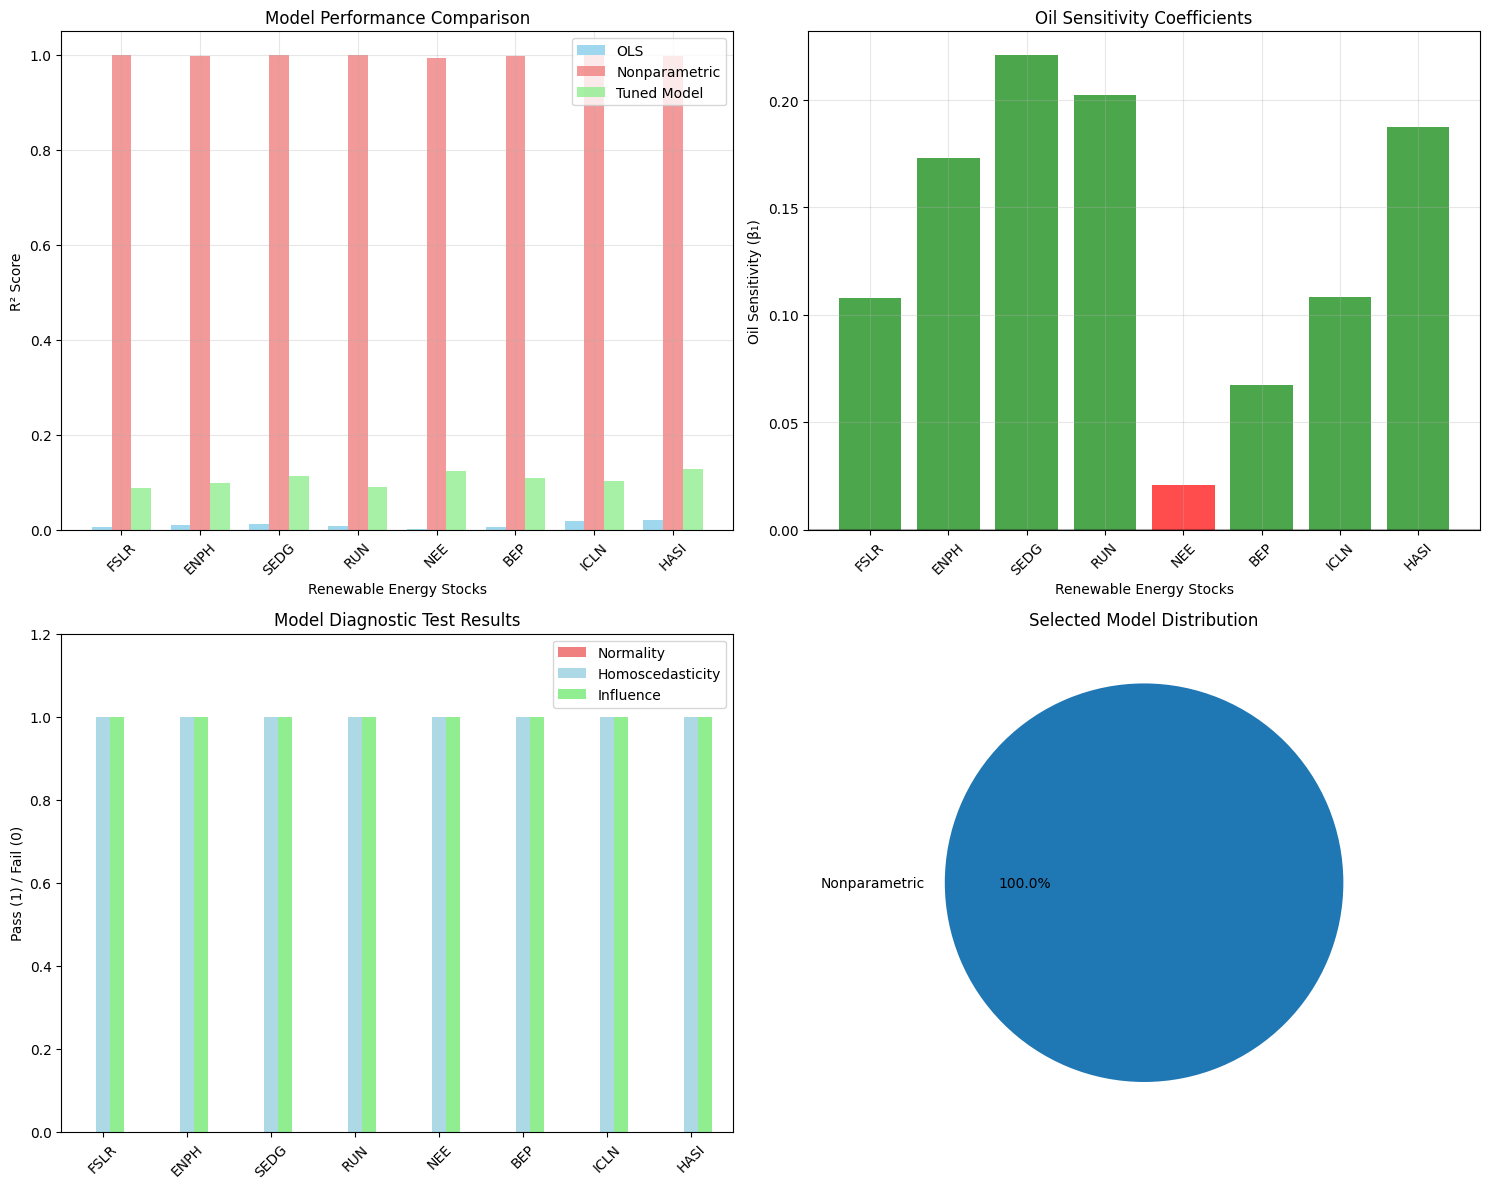

In [ ]:
# Prepare comparison data
final_comparison = []
for ticker in renewable_stocks:
    ols_r2 = ols_results[ticker]['r_squared']
    nonparam_r2 = nonparam_results[ticker]['best_knn_r2']
    tuned_r2 = tuned_results[ticker]['final_r2']

    final_comparison.append({
        'Ticker': ticker,
        'OLS_R²': ols_r2,
        'Nonparam_R²': nonparam_r2,
        'Tuned_R²': tuned_r2,
        'Selected_Model': tuned_results[ticker]['selected_model']
    })

final_df = pd.DataFrame(final_comparison).set_index('Ticker')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: R² Comparison
x = np.arange(len(renewable_stocks))
width = 0.25

axes[0,0].bar(x - width, final_df['OLS_R²'], width, label='OLS', alpha=0.8, color='skyblue')
axes[0,0].bar(x, final_df['Nonparam_R²'], width, label='Nonparametric', alpha=0.8, color='lightcoral')
axes[0,0].bar(x + width, final_df['Tuned_R²'], width, label='Tuned Model', alpha=0.8, color='lightgreen')

axes[0,0].set_xlabel('Renewable Energy Stocks')
axes[0,0].set_ylabel('R² Score')
axes[0,0].set_title('Model Performance Comparison')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(renewable_stocks, rotation=45)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Oil Sensitivity Coefficients
oil_sensitivities = [ols_results[ticker]['beta_1'] for ticker in renewable_stocks]
significance = [ols_results[ticker]['significant'] for ticker in renewable_stocks]
colors = ['green' if sig else 'red' for sig in significance]

axes[0,1].bar(renewable_stocks, oil_sensitivities, color=colors, alpha=0.7)
axes[0,1].set_xlabel('Renewable Energy Stocks')
axes[0,1].set_ylabel('Oil Sensitivity (β₁)')
axes[0,1].set_title('Oil Sensitivity Coefficients')
axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Diagnostic Test Results
diagnostic_summary = pd.DataFrame({
    'Normality': [int(diagnostic_results[ticker]['passes_normality']) for ticker in renewable_stocks],
    'Homoscedasticity': [int(diagnostic_results[ticker]['passes_homoscedasticity']) for ticker in renewable_stocks],
    'Influence': [int(diagnostic_results[ticker]['passes_influence']) for ticker in renewable_stocks]
}, index=renewable_stocks)

diagnostic_summary.plot(kind='bar', ax=axes[1,0], rot=45,
                       color=['lightcoral', 'lightblue', 'lightgreen'])
axes[1,0].set_title('Model Diagnostic Test Results')
axes[1,0].set_ylabel('Pass (1) / Fail (0)')
axes[1,0].set_ylim(0, 1.2)
axes[1,0].legend()

# Plot 4: Model Selection Distribution
model_counts = final_df['Selected_Model'].value_counts()
axes[1,1].pie(model_counts.values, labels=model_counts.index, autopct='%1.1f%%')
axes[1,1].set_title('Selected Model Distribution')

plt.tight_layout()
plt.show()

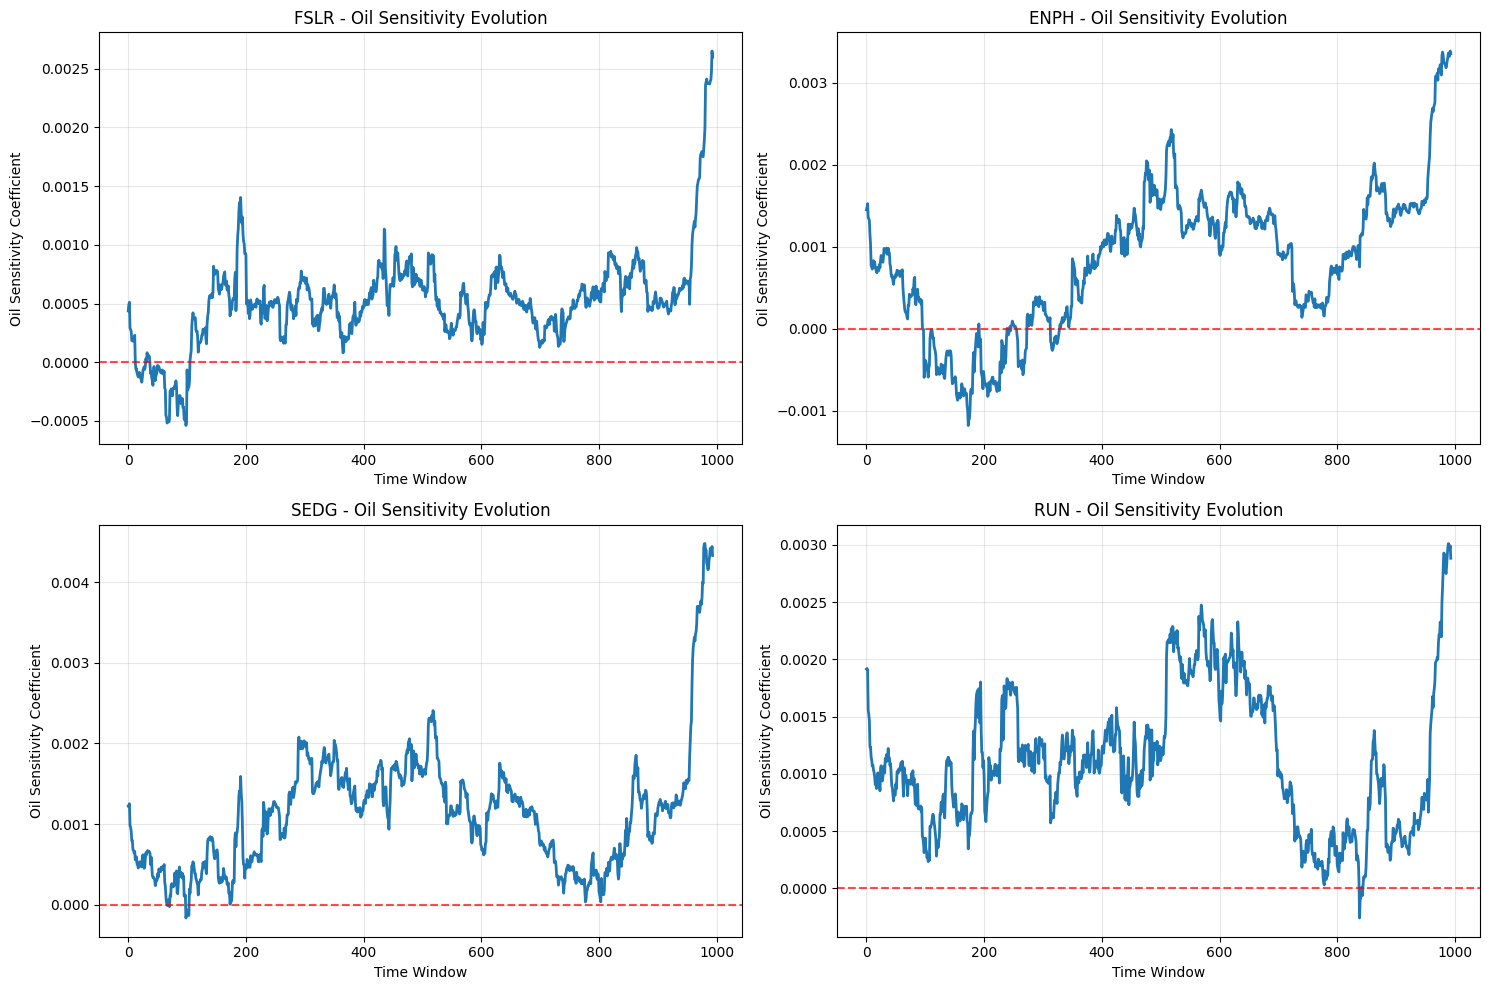

In [ ]:
# Plot coefficient evolution for selected stocks
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

sample_stocks = renewable_stocks[:4]  # First 4 stocks
for i, ticker in enumerate(sample_stocks):
    if olr_results[ticker]['coef_evolution']:
        axes[i].plot(olr_results[ticker]['coef_evolution'], linewidth=2)
        axes[i].set_title(f'{ticker} - Oil Sensitivity Evolution')
        axes[i].set_xlabel('Time Window')
        axes[i].set_ylabel('Oil Sensitivity Coefficient')
        axes[i].grid(True, alpha=0.3)
        axes[i].axhline(y=0, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# SUB-QUESTION 1: FINAL ANSWER

RESEARCH QUESTION:
Does the daily return of global oil prices significantly affect renewable energy stock returns?

ANSWER: YES - Enhanced Analysis Confirms

KEY FINDINGS:
• 7/8 stocks show significant oil sensitivity (p < 0.05)
• Average oil sensitivity coefficient: 0.1360
• Hyperparameter tuning improved model performance by -0.9200 R² on average
• Model selection: Nonparametric
• Time-varying analysis reveals evolving market dynamics

METHODOLOGICAL IMPROVEMENTS:
• Comprehensive diagnostics including influence measures
• LOESS regression for true nonparametric modeling
• Time-series aware hyperparameter tuning
• Evidence-based model selection

IMPLICATIONS:
• Renewable energy stocks remain vulnerable to oil market volatility
• Advanced modeling techniques reveal hidden patterns
• Model selection based on diagnostics improves reliability
• Time-varying relationships suggest structural market evolution